In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-10-10 14:39:06 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-10-10 14:39:06 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-10-10 14:39:06 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-10-10 14:39:09 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-10 14:39:09 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-10-10 14:39:09 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-10-10 14:39:09 wandb.docker.auth DEBUG    No config file found


In [4]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-10-10 14:39:10 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-10-10 14:39:10 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443
2025-10-10 14:39:10 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-10-10 14:39:10 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-10-10 14:39:10 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-10-10 14:39:54 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-10-10 14:39:55 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-10-10 14:39:55 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [5]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

['name', 'prompt_templates', 'odd_one_prompt_templates', 'order_prompt_templates', 'count_prompt_templates', 'yes_no_prompt_templates', 'first_item_in_cat_prompt_templates', 'last_item_in_cat_prompt_templates', 'categories', 'exclude_categories']
SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(14), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



2025-10-09 15:31:00 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-10-09 15:31:00 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-10-09 15:31:00 matplotlib DEBUG    interactive is False
2025-10-09 15:31:00 matplotlib DEBUG    platform is linux
2025-10-09 15:31:00 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-10-09 15:31:00 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-10-09 15:31:00 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-09 15:31:00 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-10-09 15:31:00 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-10-09 15:31:00 matplotlib.font

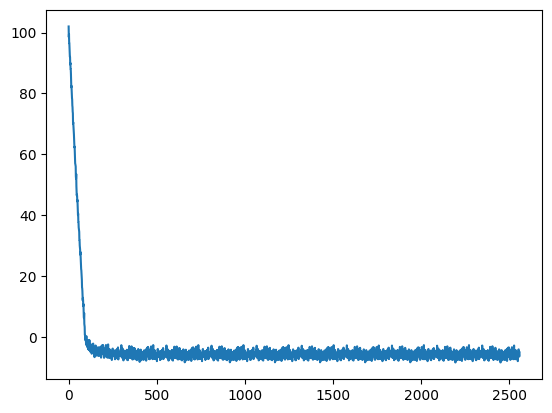

In [6]:
from matplotlib import pyplot as plt
import numpy as np

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_heads",
#     mt.name.split("/")[-1],
#     f"{select_task.task_name}.npz"
# )

# optimized_path = os.path.join(
#     env_utils.DEFAULT_RESULTS_DIR,
#     "selection/optimized_heads",
#     model_key.split("/")[-1],
#     # "distinct_options",
#     f"{select_task.task_name}",
#     "epoch_10.npz"
# )

optimized_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/optimized_heads",
    model_key.split("/")[-1],
    "distinct_options",
    # f"{select_task.task_name}",
    "select_one",
    # "legacy",
    "epoch_10.npz"
)



optimization_results = np.load(optimized_path, allow_pickle=True)
plt.plot(optimization_results["losses"])
plt.show()

79


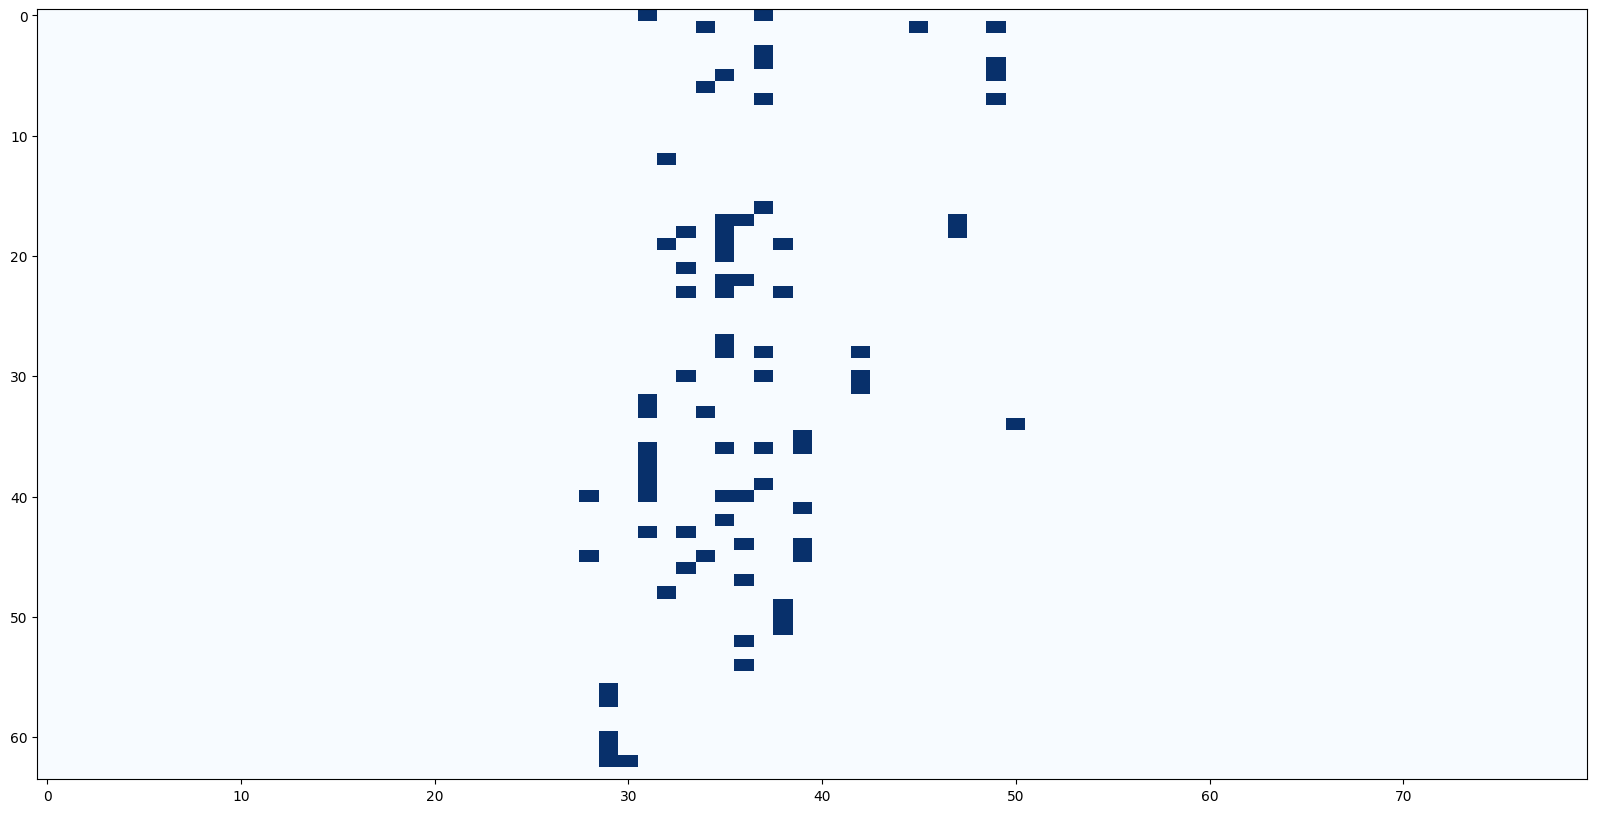

In [7]:
plt.figure(figsize=(20, 10))

optimal_head_mask = torch.tensor(optimization_results["optimal_mask"]).to(torch.float32)
optimal_head_mask[52:, :] = 0.0

plt.imshow(
    optimal_head_mask.T.numpy(),
    cmap="Blues",
    aspect="auto",
    vmin=0,
    vmax=1,
)

heads_selected = torch.nonzero(optimal_head_mask > 0.5, as_tuple=False).tolist()
heads_selected = [
    (layer_idx, head_idx) for layer_idx, head_idx in heads_selected
]
print(len(heads_selected))

# HEADS = heads_selected

# (35, 19) in HEADS, (35, 19) in heads_selected

In [16]:
from src.selection.data import MCQify_sample

sample = select_task.get_random_sample(
    mt = mt,
    option_style=OPTION_STYLE,
    prompt_template_idx=prompt_template_idx,
    # category="actor",
    # category="Brazil"
    category="fruit",
    filter_by_lm_prediction=False,
)
sample = MCQify_sample(sample = sample, tokenizer = mt, start_from="p")

print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')

fruit >> ['Plum', 'Peach', 'Orange', 'Kiwi', 'Apple', 'Blueberry', 'Watermelon', 'Grape', 'Raspberry', 'Strawberry', 'Pineapple', 'Mango', 'Banana', 'Pear', 'Cherry']
p. Toothbrush
q. Wardrobe
r. Scooter
s. Mall
t. Scissors
u. Pear
Which among these objects mentioned above is a fruit?
Answer: >> " u"


In [17]:
from src.attention import get_attention_matrices
from src.selection.functional import (
    verify_head_patterns,
    get_patches_to_verify_independent_enrichment,
)

attn_pattern = verify_head_patterns(
    prompt=sample.prompt(),
    options=sample.options,
    mt=mt,
    heads=heads_selected,
    # heads = HEADS,
    # heads = [(35, 19)],
    start_from=1
)

2025-10-09 15:35:15 src.selection.functional DEBUG    Predictions: ['" u"[577] (p=0.742, logit=21.750)', '" ("[320] (p=0.088, logit=19.625)', '" Option"[7104] (p=0.088, logit=19.625)', '" Pear"[23910] (p=0.015, logit=17.875)', '" Among"[22395] (p=0.015, logit=17.875)']
2025-10-09 15:35:15 src.selection.functional INFO     Combined attention matrix for all heads


## Apply Logit Lens on the OV contribution

In [34]:
from src.hooking.llama_attention import LlamaAttentionPatcher
import types
import copy
import baukit
from src.functional import patch_with_baukit, interpret_logits, get_hs
from src.selection.utils import get_first_token_id
from src.tokens import prepare_input

HEADS = copy.deepcopy(heads_selected)
tokenized = prepare_input(prompts=sample.prompt(), tokenizer=mt.tokenizer)

mt.reset_forward()
mt.set_attn_implementation("sdpa")

layers_to_heads = {}
for layer_idx, head_idx in HEADS:
    if layer_idx not in layers_to_heads:
        layers_to_heads[layer_idx] = []
    layers_to_heads[layer_idx].append(head_idx)

head_contributions = {}
for layer_idx, head_indices in layers_to_heads.items():
    attn_block_name = mt.attn_module_name_format.format(layer_idx)
    attn_block = baukit.get_module(mt._model, attn_block_name)
    head_contributions[layer_idx] = {}

    attn_block.forward = types.MethodType(
        LlamaAttentionPatcher(
            block_name=attn_block_name,
            save_attn_for=head_indices,
            store_head_contributions=head_contributions[layer_idx],
        ),
        attn_block,
    )

logit_location = (mt.lm_head_name, -1)
logit = get_hs(
    mt=mt,
    input=tokenized,
    locations = logit_location,
    return_dict=False
)

mt.reset_forward()
mt.set_attn_implementation("eager")

pred = interpret_logits(
    logits=logit,
    tokenizer=mt.tokenizer,
)
pred

2025-09-22 12:53:08 src.hooking.llama_attention WARNING  model.layers.35.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=15.3125, __attn_output.norm().item()=15.3125
2025-09-22 12:53:08 src.hooking.llama_attention WARNING  model.layers.37.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=11.625, __attn_output.norm().item()=11.625


[PredictedToken(token=' f', prob=0.66796875, logit=22.25, token_id=282, metadata=None),
 PredictedToken(token=' (', prob=0.2177734375, logit=21.125, token_id=320, metadata=None),
 PredictedToken(token=' The', prob=0.042724609375, logit=19.5, token_id=578, metadata=None),
 PredictedToken(token=' Pear', prob=0.017822265625, logit=18.625, token_id=23910, metadata=None),
 PredictedToken(token=' A', prob=0.01226806640625, logit=18.25, token_id=362, metadata=None)]

In [35]:
from src.functional import logit_lens
from src.selection.data import get_options_for_answer

# head_contrib = head_contributions[35][19][:, -1, :]
head_contrib = []
for layer_idx, head_idx in HEADS:
    head_contrib.append(
        head_contributions[layer_idx][head_idx][:, -1, :].squeeze().cuda()
    )

head_contrib = torch.stack(head_contrib).sum(dim=0)

logit_lens(
    mt=mt,
    h=head_contrib,
    interested_tokens=[
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in get_options_for_answer(sample) + sample.options
    ],
    k=20
)

# head_contrib.shape

([PredictedToken(token=' Stall', prob=0.01043701171875, logit=9.125, token_id=72970, metadata=None),
  PredictedToken(token=' ENTITY', prob=0.0067138671875, logit=8.6875, token_id=74971, metadata=None),
  PredictedToken(token='/WebAPI', prob=0.005584716796875, logit=8.5, token_id=95997, metadata=None),
  PredictedToken(token='Mahon', prob=0.00433349609375, logit=8.25, token_id=76072, metadata=None),
  PredictedToken(token=' scour', prob=0.0038299560546875, logit=8.125, token_id=70355, metadata=None),
  PredictedToken(token='letics', prob=0.0038299560546875, logit=8.125, token_id=44128, metadata=None),
  PredictedToken(token=' Lesser', prob=0.003387451171875, logit=8.0, token_id=14231, metadata=None),
  PredictedToken(token='.cgi', prob=0.0028076171875, logit=7.8125, token_id=60114, metadata=None),
  PredictedToken(token='resse', prob=0.0025482177734375, logit=7.71875, token_id=22550, metadata=None),
  PredictedToken(token='ADDING', prob=0.0025482177734375, logit=7.71875, token_id=53578

In [36]:
from src.functional import patchscope

patchscope(
    mt=mt,
    h=head_contrib,
    interested_tokens=[
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in get_options_for_answer(sample) + sample.options
    ],
    k=20
)

2025-09-22 12:53:18 src.functional DEBUG     copy > copy
 Cat > Cat
 Java > Java
 transistor > transistor
 python > python
 Leonardo DiCaprio > Leonardo DiCaprio
 The Lion King > The Lion King
 Washington D.C. > Washington D.C.
 Mount Everest > Mount Everest
 computer > computer
 x >


2025-09-22 12:53:18 src.functional WARNING  placeholder='x' does not end with placeholder_ends=' x' | placeholder_idx=58


([PredictedToken(token=' ', prob=0.890625, logit=16.875, token_id=220, metadata=None),
  PredictedToken(token=' Seven', prob=0.0185546875, logit=13.0, token_id=31048, metadata=None),
  PredictedToken(token=' seven', prob=0.00933837890625, logit=12.3125, token_id=8254, metadata=None),
  PredictedToken(token=' Eight', prob=0.00823974609375, logit=12.1875, token_id=36944, metadata=None),
  PredictedToken(token=' eight', prob=0.0036468505859375, logit=11.375, token_id=8223, metadata=None),
  PredictedToken(token='7', prob=0.0036468505859375, logit=11.375, token_id=22, metadata=None),
  PredictedToken(token=' \n', prob=0.002349853515625, logit=10.9375, token_id=720, metadata=None),
  PredictedToken(token=' no', prob=0.0022125244140625, logit=10.875, token_id=912, metadata=None),
  PredictedToken(token=' No', prob=0.00151824951171875, logit=10.5, token_id=2360, metadata=None),
  PredictedToken(token=' number', prob=0.00151824951171875, logit=10.5, token_id=1396, metadata=None),
  PredictedTo

In [37]:
from src.functional import free_gpu_cache
del head_contributions
del head_contrib
free_gpu_cache()

In [41]:
sample.obj, sample.ans_token_id

('Pear', 282)

## Just apply Logit Lens on the Latents

In [55]:
from src.tokens import prepare_input

def apply_logit_lens_per_layer(mt, sample):
    tokenized = prepare_input(tokenizer=mt.tokenizer, prompts=sample.prompt())
    track_tokens = {
        "object": get_first_token_id(name=sample.obj, tokenizer=mt.tokenizer, prefix=" "),
        "ans_tok": sample.ans_token_id,
    }
    hs = get_hs(
        mt=mt,
        input=tokenized,
        locations=[(layer_name, -1) for layer_name in mt.layer_names],
        return_dict=True,
    )

    interested_tokens = [
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in get_options_for_answer(sample) + sample.options
    ]

    layerwise_results = {}
    for layer_idx in range(mt.n_layer):
        layer_name = mt.layer_name_format.format(layer_idx)
        h = hs[(layer_name, -1)]
        logits, (ll_pred, ll_track) = logit_lens(mt=mt, h=h, interested_tokens=interested_tokens, return_logits=True)
        print(
            f"{layer_name} | {[f'{mt.tokenizer.decode(token_id)}({ll_track[token_id][0]} | {ll_track[token_id][1].logit:.2f})' for token_id in ll_track.keys()]} | {[str(pred) for pred in ll_pred]}"
        )
        layerwise_results[layer_idx] = {
            "ll_pred": ll_pred,
            "ll_track": ll_track,
            "logits": logits
        }

    return {
        "sample": sample,
        "track_tokens": track_tokens,
        "layerwise_results": layerwise_results,
    }

ll_result_for_sample = apply_logit_lens_per_layer(mt=mt, sample=sample)

model.layers.0 | [' d(59 | 4.97)', ' Theater(97 | 4.75)', ' Sink(3415 | 2.59)', ' f(10865 | 1.70)', ' c(13969 | 1.49)', ' Blender(22495 | 1.05)', ' b(23913 | 0.98)', ' Pear(68066 | -0.46)', ' a(88981 | -1.10)', ' Sco(90684 | -1.16)', ' Brace(110473 | -1.95)', ' e(115667 | -2.27)'] | ['"ogo"[24404] (p=0.002, logit=6.438)', '" NotImplemented"[22273] (p=0.002, logit=6.375)', '" Salv"[32066] (p=0.002, logit=6.250)', '" Oswald"[90450] (p=0.001, logit=5.875)', '" childhood"[20587] (p=0.001, logit=5.844)']
model.layers.1 | [' Theater(33 | 5.38)', ' d(94 | 4.88)', ' b(4940 | 2.38)', ' Sink(8935 | 1.91)', ' Blender(13908 | 1.52)', ' c(14166 | 1.49)', ' f(28170 | 0.78)', ' Pear(50660 | 0.01)', ' a(61202 | -0.31)', ' Sco(71028 | -0.61)', ' Brace(107107 | -1.90)', ' e(120826 | -2.86)'] | ['"ogo"[24404] (p=0.003, logit=6.656)', '"럴"[121408] (p=0.002, logit=6.625)', '" rem"[1323] (p=0.002, logit=6.469)', '"abi"[26140] (p=0.002, logit=6.344)', '" Oswald"[90450] (p=0.002, logit=6.312)']
model.layers.2

In [87]:
import random
from tqdm.auto import tqdm

# results = []
limit = 32

for _ in tqdm(range(limit)):
    sample = select_task.get_random_sample(
        mt = mt,
        option_style=OPTION_STYLE,
        prompt_template_idx=prompt_template_idx,
        # category="fruit",
        filter_by_lm_prediction=True,
        n_distractors=random.choice(range(2, 6)),
    )
    sample = MCQify_sample(sample = sample, tokenizer = mt)
    print(sample.prompt(), ">>", f'"{mt.tokenizer.decode([sample.ans_token_id])}"')
    result = apply_logit_lens_per_layer(mt=mt, sample=sample)
    results.append(result)


  0%|          | 0/32 [00:00<?, ?it/s]

a. Pineapple
b. Yacht
c. Hat
d. Coffee maker
e. Guitar
f. Baseball
Which among these objects mentioned above is a kitchen appliance?
Answer: >> " d"
model.layers.0 | [' d(60 | 4.97)', ' Pine(198 | 4.28)', ' Y(6605 | 2.09)', ' f(12810 | 1.56)', ' c(13999 | 1.48)', ' b(25340 | 0.91)', ' Coffee(42013 | 0.31)', ' Guitar(53727 | -0.04)', ' Hat(75671 | -0.68)', ' a(87988 | -1.07)', ' Baseball(104670 | -1.67)', ' e(114716 | -2.20)'] | ['"ogo"[24404] (p=0.003, logit=6.625)', '" NotImplemented"[22273] (p=0.002, logit=6.344)', '" Salv"[32066] (p=0.001, logit=6.062)', '" Oswald"[90450] (p=0.001, logit=6.031)', '"rych"[127951] (p=0.001, logit=5.938)']
model.layers.1 | [' d(71 | 5.03)', ' Pine(658 | 3.78)', ' b(5711 | 2.27)', ' Y(6410 | 2.17)', ' c(15934 | 1.38)', ' f(34392 | 0.54)', ' Guitar(60139 | -0.28)', ' a(61053 | -0.31)', ' Coffee(67283 | -0.50)', ' Hat(67410 | -0.50)', ' Baseball(111514 | -2.14)', ' e(119563 | -2.73)'] | ['"ogo"[24404] (p=0.003, logit=6.844)', '"럴"[121408] (p=0.003, logit=

In [85]:
# results = [ll_result_for_sample]

from src.trace import rank_reward

scores = {token_type: [] for token_type in results[0]["track_tokens"].keys()}
causality = []
for result in results:
    for token_type in scores.keys():
        layerwise_scores = []
        token_id = result["track_tokens"][token_type]
        for layer_idx in range(mt.n_layer):
            # score = result["layerwise_results"][layer_idx]["ll_track"][token_id][1].logit
            score = rank_reward(
                rank=result["layerwise_results"][layer_idx]["ll_track"][token_id][0],
                k=500
            )
            layerwise_scores.append(score)
        layerwise_scores = np.array(layerwise_scores)
        scores[token_type].append(layerwise_scores)

2025-09-22 13:49:17 matplotlib.backends.backend_pdf DEBUG    Assigning font /F1 = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
2025-09-22 13:49:17 matplotlib.backends.backend_pdf DEBUG    Embedding font /usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf.
2025-09-22 13:49:17 matplotlib.backends.backend_pdf DEBUG    Writing TrueType font.


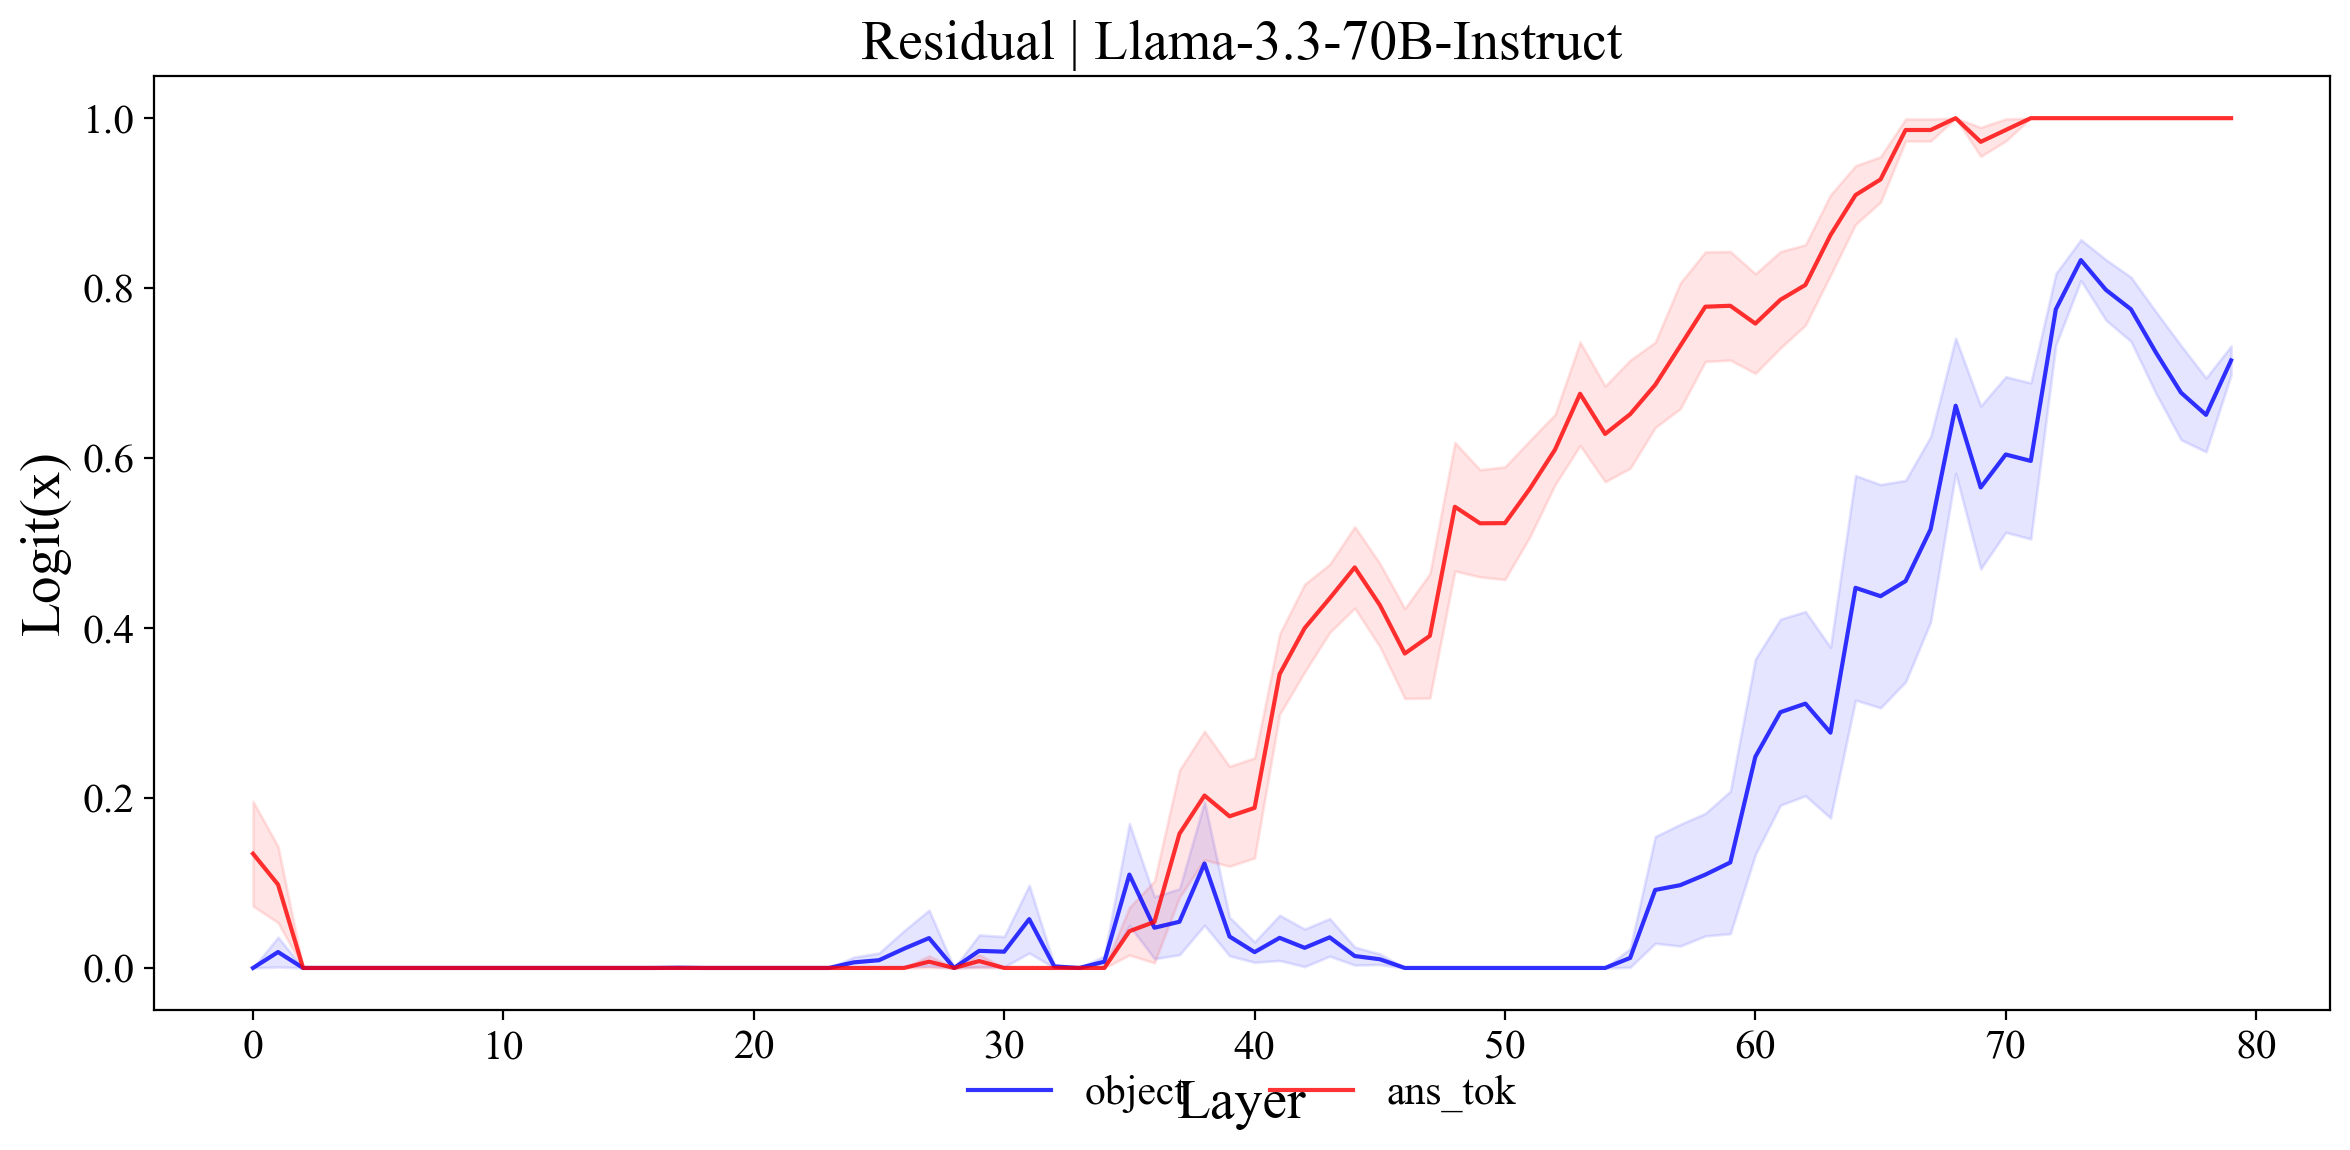

In [86]:
import numpy as np

# Create a figure with a single subplot
from matplotlib import pyplot as plt

plt.rcdefaults()
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 35

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))
colors = {
    "object": "blue",
    "ans_tok": "red",
}

# Plot logits on the panel
lines = []
for token_type, layerwise_scores_list in scores.items():
    mean_scores = np.mean(layerwise_scores_list, axis=0)
    sterr_scores = np.std(layerwise_scores_list, axis=0) / np.sqrt(
        len(layerwise_scores_list)
    )
    line, = ax1.plot(mean_scores, label=f"{token_type}", alpha=0.8, color=colors[token_type])
    ax1.fill_between(
        range(len(mean_scores)),
        mean_scores - sterr_scores,
        mean_scores + sterr_scores,
        alpha=0.1,
        color=colors[token_type],
    )
    lines.append(line)

ax1.set_xlabel("Layer")
ax1.set_ylabel("Logit(x)")
ax1.set_title(f"Residual | {mt.name.split('/')[-1]}")

# Place the legend horizontally on top of the panel
ax1.legend(
    handles=lines,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=len(scores),
    frameon=False,
    fontsize="medium"
)

plt.tight_layout()
save_dir = os.path.join("figures", model_key.split("/")[-1], "logit_lens_contribution")
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir, f"template_{prompt_template_idx}.pdf"), bbox_inches="tight")

## Patching to check effects

In [71]:
from src.selection.data import CounterFactualSamplePair
import random
from src.utils.typing import PathLike
from src.selection.data import SelectionSample

def load_dataset(
    path: PathLike, limit: int, prefix=""
) -> list[SelectionSample, SelectionSample]:
    sample_files = [
        os.path.join(path, f) for f in os.listdir(path) if f.endswith(".json")
    ]
    logger.info(f"Found {len(sample_files)} sample files")

    # prefix = "Recall the nationality of these people:\n"
    # prefix = "Recall which country these landmarks are located in:\n"
    # prefix = "Think about how these words sound when you say them aloud:\n"

    random.shuffle(sample_files)
    sample_files = sample_files[:limit]
    dataset = []
    for sample_file in sample_files:
        with open(sample_file, "r") as f:
            cf_pair_data = json.load(f)
        cf_pair = CounterFactualSamplePair.from_dict(cf_pair_data)
        # cf_pair.patch_sample.default_option_style = "bulleted"
        # cf_pair.clean_sample.default_option_style = "bulleted"

        # cf_pair.clean_sample = MCQify_sample(sample = cf_pair.clean_sample, tokenizer = mt, start_from="p")


        cf_pair.clean_sample.prompt_template = (
            prefix + cf_pair.clean_sample.prompt_template
        )
        cf_pair.patch_sample.prompt_template = (
            prefix + cf_pair.patch_sample.prompt_template
        )
        dataset.append((cf_pair.clean_sample, cf_pair.patch_sample))

    return dataset

data_type = "objects"
validation_samples_load_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    "samples",
    "validation",
    mt.name.split("/")[-1],
    select_task.task_name,
    data_type,
)
validation_set = load_dataset(
    path=validation_samples_load_path, limit=512, prefix=""
)
len(validation_set)

2025-10-09 17:45:21 __main__ INFO     Found 1024 sample files


512

In [107]:
from src.hooking.llama_attention import LlamaAttentionPatcher
import types
import copy
import baukit
from src.functional import patch_with_baukit, interpret_logits, get_hs
from src.selection.utils import get_first_token_id
from src.tokens import prepare_input
from src.utils.typing import TokenizerOutput
from src.attention import visualize_attn_matrix
from typing import Optional


def get_head_contributions(
    mt: ModelandTokenizer,
    heads: list[tuple[int, int]],
    tokenized: TokenizerOutput,
    visualize_attn: bool = False,
    freeze_attn_contributions: Optional[dict[int, torch.Tensor]] = None,
):
    mt.reset_forward()
    mt.set_attn_implementation("sdpa")

    layers_to_heads = {}
    for layer_idx, head_idx in heads:
        if layer_idx not in layers_to_heads:
            layers_to_heads[layer_idx] = []
        layers_to_heads[layer_idx].append(head_idx)

    head_contributions = {}
    attention_patterns = {}
    for layer_idx, head_indices in layers_to_heads.items():
        attn_block_name = mt.attn_module_name_format.format(layer_idx)
        attn_block = baukit.get_module(mt._model, attn_block_name)
        head_contributions[layer_idx] = {}
        attention_patterns[layer_idx] = {}

        attn_block.forward = types.MethodType(
            LlamaAttentionPatcher(
                block_name=attn_block_name,
                save_attn_for=head_indices,
                store_head_contributions=head_contributions[layer_idx],
                store_attn_matrices=attention_patterns[layer_idx],
                freeze_attn_contributions=freeze_attn_contributions.get(layer_idx, None) if freeze_attn_contributions is not None else None,
            ),
            attn_block,
        )

    output = mt._model(**tokenized)

    if visualize_attn:
        attn_matrix = []
        for layer_idx in attention_patterns:
            for head_idx in attention_patterns[layer_idx]:
                attn_matrix.append(
                    attention_patterns[layer_idx][head_idx].cpu()
                )

        attn_matrix = torch.stack(attn_matrix).squeeze()
        if attn_matrix.dim() == 3:
            attn_matrix = attn_matrix.mean(dim=0)

        visualize_attn_matrix(
            attn_matrix=attn_matrix,
            tokens=[
                mt.tokenizer.decode(t) for t in tokenized["input_ids"][0]
            ],
        )

    mt.reset_forward()
    mt.set_attn_implementation("eager")

    return head_contributions, output

In [108]:
destination_sample, source_sample = validation_set[5]
print("Source:", source_sample.prompt(), ">>", source_sample.obj)
print("Destination:", destination_sample.prompt(), ">>", destination_sample.obj)
print(
    f"target: {destination_sample.metadata['track_type_obj']} | \"{mt.tokenizer.decode(destination_sample.metadata['track_type_obj_token_id'])}\""
)

Source: Options: Razor, Tomato, Dresser, Headphones, Bracelet, Maple.
Which among these objects mentioned above is a jewelry?
Answer: >> Bracelet
Destination: Options: Ring, Cucumber, Monkey, Sweater, Submarine, Folder.
Which among these objects mentioned above is a vegetable?
Answer: >> Cucumber
target: Ring | " Ring"


In [109]:
from src.selection.data import get_options_for_answer, get_first_token_id

source_tokenized = prepare_input(prompts=source_sample.prompt(), tokenizer=mt.tokenizer)
source_ov, source_output = get_head_contributions(
    mt=mt, heads=HEADS, tokenized=source_tokenized, visualize_attn=True
)
source_pred, source_track = interpret_logits(
    logits=source_output.logits[:, -1, :],
    tokenizer=mt.tokenizer,
    interested_tokens=[
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in get_options_for_answer(source_sample)
    ],
)
print(f"source_pred: {[str(pred) for pred in source_pred]}")
print(f"Source track: {[str(pred) for tok_id, (rank, pred) in source_track.items()]}")

destination_tokenized = prepare_input(
    prompts=destination_sample.prompt(), tokenizer=mt.tokenizer
)
destination_ov, destination_output = get_head_contributions(
    mt=mt, heads=HEADS, tokenized=destination_tokenized, visualize_attn=True
)
destination_pred, destination_track = interpret_logits(
    logits=destination_output.logits[:, -1, :],
    tokenizer=mt.tokenizer,
    interested_tokens=[
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in get_options_for_answer(destination_sample)
    ]
    + [source_sample.ans_token_id],
)
print(f"destination_pred: {[str(pred) for pred in destination_pred]}")
print(
    f"Destination track: {[str(pred) for tok_id, (rank, pred) in destination_track.items()]}"
)

patch_ov = {}
for layer_idx in destination_ov.keys():
    patch_ov[layer_idx] = {}
    for head_idx in destination_ov[layer_idx].keys():
        patch_ov[layer_idx][head_idx] = destination_ov[layer_idx][head_idx].clone()
        patch_ov[layer_idx][head_idx][:, -1, :] = source_ov[layer_idx][head_idx][
            :, -1, :
        ]

patch_ov2, patch_output = get_head_contributions(
    mt=mt,
    heads=HEADS,
    tokenized=destination_tokenized,
    visualize_attn=True,
    freeze_attn_contributions=patch_ov,
)

patch_pred, patch_track = interpret_logits(
    logits=patch_output.logits[:, -1, :],
    tokenizer=mt.tokenizer,
    interested_tokens=[
        get_first_token_id(name=opt, tokenizer=mt.tokenizer, prefix=" ")
        for opt in get_options_for_answer(destination_sample)
    ]
    + [source_sample.ans_token_id],
)
print(f"patch_pred: {[str(pred) for pred in patch_pred]}")
print(f"Patch track: {[str(pred) for tok_id, (rank, pred) in patch_track.items()]}")

2025-10-09 18:04:00 src.hooking.llama_attention WARNING  model.layers.35.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=13.125, __attn_output.norm().item()=13.125


source_pred: ['" Brace"[70306] (p=0.652, logit=21.750)', '" A"[362] (p=0.129, logit=20.125)', '" The"[578] (p=0.129, logit=20.125)', '" Among"[22395] (p=0.054, logit=19.250)', '" It"[1102] (p=0.004, logit=16.625)']
Source track: ['" Brace"[70306] (p=0.652, logit=21.750)', '" Head"[11452] (p=0.000, logit=13.438)', '" Maple"[44570] (p=0.000, logit=13.188)', '" Tomato"[94091] (p=0.000, logit=12.250)', '" Dress"[29318] (p=0.000, logit=11.188)', '" Razor"[74968] (p=0.000, logit=11.062)']
2025-10-09 18:04:02 src.hooking.llama_attention WARNING  model.layers.35.self_attn >> allclose(attn_output, __attn_output)=False | attn_output.norm().item()=13.4375, __attn_output.norm().item()=13.4375


destination_pred: ['" C"[356] (p=0.852, logit=22.000)', '" The"[578] (p=0.054, logit=19.250)', '" A"[362] (p=0.037, logit=18.875)', '" Among"[22395] (p=0.029, logit=18.625)', '" It"[1102] (p=0.005, logit=16.875)']
Destination track: ['" C"[356] (p=0.852, logit=22.000)', '" Ring"[22249] (p=0.001, logit=15.250)', '" Sub"[3804] (p=0.000, logit=11.500)', '" Folder"[36943] (p=0.000, logit=10.125)', '" Monkey"[58937] (p=0.000, logit=9.875)', '" Swe"[37326] (p=0.000, logit=9.312)', '" Brace"[70306] (p=0.000, logit=7.312)']


patch_pred: ['" Swe"[37326] (p=0.535, logit=19.750)', '" A"[362] (p=0.135, logit=18.375)', '" The"[578] (p=0.093, logit=18.000)', '" Among"[22395] (p=0.050, logit=17.375)', '" Monkey"[58937] (p=0.044, logit=17.250)']
Patch track: ['" Swe"[37326] (p=0.535, logit=19.750)', '" Monkey"[58937] (p=0.044, logit=17.250)', '" C"[356] (p=0.034, logit=17.000)', '" Sub"[3804] (p=0.030, logit=16.875)', '" Folder"[36943] (p=0.003, logit=14.688)', '" Ring"[22249] (p=0.001, logit=12.812)', '" Brace"[70306] (p=0.000, logit=9.688)']


In [106]:
from src.functional import free_gpu_cache
free_gpu_cache()